#### Analyzing output files from spark 
The output files were stored in hdfs and are periodically moved to s3.
The sentiment analysis output was stored in local file 'counts_and_sentiments.txt' and is updated while the spark is running. This file is also uploaded to s3 periodically overwriting the contents of the file on s3.

In [1]:
import boto
import matplotlib.pyplot as plt
import re
import datetime


In [2]:
AWS_ACCESS_KEY_ID = ''
AWS_SECRET_KEY = ''
bucket_name = '251mids'

In [3]:
s3_connection = boto.connect_s3(AWS_ACCESS_KEY_ID, AWS_SECRET_KEY)
bucket = s3_connection.get_bucket(bucket_name)


##### Keywords
Using the list of files in s3, we first find the files that contain the keywords output.   
Because of the sort performed in spark, we get top keywords in part-00000 and part-00001 files. However, we look through all the part files here.  
The keywords are stored as a dictionary of dictionaries.  
keyword_keys === {Date: {keyword: count, }, }  
The date is obtained from the directory containing the part-* files.

In [4]:
keyword_keys = {}
for keys in bucket.list():
    if re.match(r".*keyword.*part.*", keys.name):
        ts = int(re.findall(r'[0-9]{8,}', keys.name)[0])/1000
        ts = datetime.datetime.fromtimestamp(ts)
        day = ts.date()
        contents = keys.get_contents_as_string()
        contents = contents.strip().split('\n')
        contents = {line.split('\t')[0]: int(line.split('\t')[1]) for line in contents if len(line) != 0}
        if keyword_keys.get(day, None):
            old_contents = keyword_keys[day]
            for word in contents.keys():
                old_contents[word] = old_contents.get(word, 0) + contents[word]
            keyword_keys[day] = old_contents
        else:
            keyword_keys[day] = contents

keywords = [(u[0], u[1].items()) for u in keyword_keys.items()]
keywords = sorted(keywords, key=lambda x: x[0])
keywords = [(u[0], sorted(u[1], key=lambda x: x[1], reverse=True)) for u in keywords]
N = 10
for day, words in keywords:
    print '\n', day
    for word, count in words[:N]:
            print word, count


2016-04-12
vote 11679
cruz 10442
york 6442
president 6026
gop 5421
ted 4802
endorses 4599
delegates 3793
ny 3503
wall 3479

2016-04-13
cruz 18396
vote 17675
president 12238
campaign 10777
york 10007
rally 9489
gop 9395
people 8493
ted 8329
endorses 8329

2016-04-14
vote 21767
cruz 19361
gop 11238
york 10777
ted 9848
ny 9603
campaign 8870
president 7992
people 7858
wall 7526

2016-04-15
vote 17138
president 15449
cruz 15188
endorses 14832
rally 7525
gop 7515
htt 6815
watch 6707
ted 6558
york 6550

2016-04-16
vote 16685
cruz 13444
president 11407
htt 10534
endorses 8668
york 8608
ted 7838
rally 7105
people 6492
gop 6336

2016-04-17
vote 26417
cruz 19630
york 15060
president 12814
endorses 9991
htt 9807
ted 9037
delegates 8693
people 8442
30 7966

2016-04-18
vote 9018
president 7807
endorses 7596
cruz 5871
york 5455
ht 4850
america 4160
htt 3760
support 3486
great 3214


##### Number of references to trump
Using the s3 data, we find the number of tweets gathered for trump every hour and create a plot.

In [5]:
total_keys = {}
for keys in bucket.list():
    if re.match(r".*tweet.*part.*", keys.name):
        ts = int(re.findall(r'[0-9]{8,}', keys.name)[0])/1000
        ts = datetime.datetime.fromtimestamp(ts)
        hour = datetime.datetime.strptime(datetime.datetime.strftime(ts, "%H:00:00 %Y-%m-%d"), "%H:00:00 %Y-%m-%d")
        contents = keys.get_contents_as_string()
        contents = contents.strip().split('\n')
        contents = sum([int(line.split('\t')[-1]) for line in contents if len(line) != 0])
        total_keys[hour] = total_keys.get(hour, 0) + contents
#print total_keys.keys()

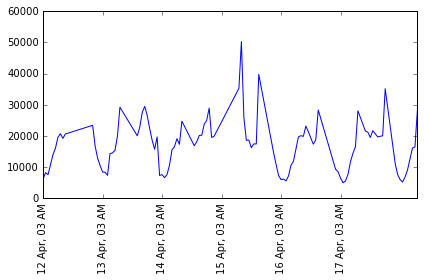

In [6]:
%matplotlib inline
total_mentions = sorted(total_keys.items(), key=lambda x: x[0])
plt.plot(zip(*total_mentions)[0], zip(*total_mentions)[1])
maxts = list(zip(*total_mentions)[0])[-1]
mints = list(zip(*total_mentions)[0])[0]
tseconds = maxts - mints
tseconds = tseconds.days
l = range(0, tseconds, 1)
u = [mints + datetime.timedelta(days=i) for i in l]
v = [datetime.datetime.strftime(i, '%d %b, %I %p') for i in u]
plt.xticks(u, v, rotation=90)
plt.tight_layout()
plt.show()

##### Sentiment
Using the file 'count_and_sentiments.txt' uploaded to s3, we find overall sentiment of the tweets and plot the hourly average sentiment.

In [7]:
for keys in bucket.list():
    if keys.name.startswith('count_'):
        counts_and_sentiments = keys.get_contents_as_string()
        break
#print counts_and_sentiments

In [8]:
ts = 'Thu Apr 14 16:23:46 CDT 2016'
p = datetime.datetime.strptime
f = datetime.datetime.strftime
n = datetime.datetime.now()
print f(n, '%a %b %d %H:%M:%S CDT %Y')
print p(ts, '%a %b %d %H:%M:%S CDT %Y')

Tue Apr 19 03:31:28 CDT 2016
2016-04-14 16:23:46


In [9]:
all_sentiments = {}
sums = 0
counts = 0
ts = None
for line in counts_and_sentiments.split('\n'):
    if not line.strip():
        continue
    try:
        ts = datetime.datetime.strptime(line.strip(), '%a %b %d %H:%M:%S CDT %Y')
        ts = datetime.datetime.strptime(datetime.datetime.strftime(ts, '%H:00:00 %Y-%m-%d'), '%H:00:00 %Y-%m-%d')
    except:
        c = re.findall('([0-9]+)\t([\-0-9]+\.[0-9]+)', line)
        if c:
            sent = float(c[-1][1])
            counts = int(c[-1][0])
            sums = sent * counts
            s, c = all_sentiments.get(ts, (0, 0))
            s += sums
            c += counts
            all_sentiments[ts] = (s, c)
            #print ts, sent, counts, sums, s, c
all_sentiments = [(u[0], u[1][0] / u[1][1]) for u in all_sentiments.items()]
all_sentiments = sorted(all_sentiments, key=lambda x: x[0])

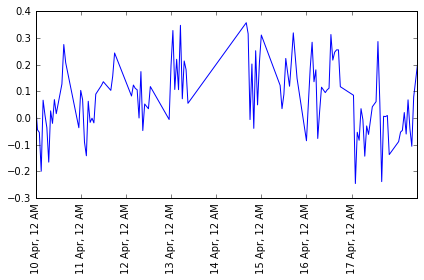

In [10]:
%matplotlib inline
plt.plot(zip(*all_sentiments)[0], zip(*all_sentiments)[1])
maxts = list(zip(*all_sentiments)[0])[-1]
mints = list(zip(*all_sentiments)[0])[0]
tseconds = maxts - mints
tseconds = tseconds.days
l = range(0, tseconds, 1)
u = [mints + datetime.timedelta(days=i) for i in l]
v = [datetime.datetime.strftime(i, '%d %b, %I %p') for i in u]
plt.xticks(u, v, rotation=90)
plt.tight_layout()
plt.show()

###### Tweets
Find the hours when most tweets were posted and print the top keywords, hashtags for that hour. 

In [11]:
# collect all keys
hashtag_keys = {}
tweets_keys = {}
keyword_keys = {}
places_keys = {}
all_timestamps = []
for key in bucket.list():
    try:
        ts = datetime.datetime.fromtimestamp(int(re.findall(r'[0-9]{9,}', key.name)[0]) / 1000)
    except:
        continue
    ts = datetime.datetime.strptime(datetime.datetime.strftime(ts, '%H:00:00 %Y-%m-%d'), '%H:00:00 %Y-%m-%d')
    all_timestamps.append(ts)
    if re.match(r'.*keyword.*part.*', key.name):
        keys = keyword_keys.get(ts, [])
        keys.append(key)
        keyword_keys[ts] = keys
    elif re.match(r'.*hashtag.*part.*', key.name):
        keys = hashtag_keys.get(ts, [])
        keys.append(key)
        hashtag_keys[ts] = keys
    elif re.match(r'.*tweet.*part.*', key.name):
        keys = tweets_keys.get(ts, [])
        keys.append(key)
        tweets_keys[ts] = keys
    elif re.match(r'.*place.*part.*', key.name):
        keys = places_keys.get(ts, [])
        keys.append(key)
        places_keys[ts] = keys

In [12]:
def get_sorted(agg):
    out = {}
    for timestamp in agg.keys():
        contents = []
        for key in agg[timestamp]:
            cont = key.get_contents_as_string().strip().split('\n')
            cont = [(u.split('\t')[0], int(u.split('\t')[1])) for u in cont if len(u.strip().split('\t')) == 2]
            contents.extend(cont)
        contents = sorted(contents, key=lambda x: x[1], reverse=True)
        out[timestamp] = contents
    return out

agg_keywords = get_sorted(keyword_keys)
agg_hashtags = get_sorted(hashtag_keys)
agg_tweets = get_sorted(tweets_keys)
agg_places = get_sorted(places_keys)
agg_sentiments = {u[0]: u[1] for u in all_sentiments}

In [13]:
tweet_counts = {ts: sum([u[1] for u in agg_tweets[ts]]) for ts in agg_tweets.keys()}
t = tweet_counts.items()
t = sorted(t, key=lambda x: x[1], reverse=True)
N = 10
for u in t[:N]:
    ts = u[0]
    h = ts.hour
    p1 = 'am' if (ts.hour - 1) < 12 else 'pm'
    p = 'am' if (ts.hour) < 12 else 'pm'
    print 
    print datetime.datetime.strftime(ts, '%b %d'), '%d%s-%d%s'% ((ts.hour - 1) % 12, p1,  ts.hour % 12, p)
    print 'total tweets: %d' % u[1]
    ls = agg_keywords.get(ts)
    hs = agg_hashtags.get(ts)
    sents = agg_sentiments.get(ts, 0)
    print 'overall average sentiment: %f' % sents
    if ls:
        print '\t\tTop keywords'
        for keyword in ls[:N]:
            print keyword[0], keyword[1]
    if hs:
        print '\t\tTop hashtags'
        for hashtag in hs[:N]:
            print hashtag[0], hashtag[1]
    


Apr 15 10am-11am
total tweets: 50277
overall average sentiment: 0.035008
		Top keywords
vote 3624
cruz 2925
media 1916
man 1459
wisconsin 1410
doesn 1395
endorses 1374
rally 1359
de 1351
shares 1244
		Top hashtags
#Trump 4964
#Trump2016 1754
#NeverTrump 1147
#Wisconsin 993
#TRUMP 917
#trump 659
#WIPrimary 605
#TrumpTrain 552
#MakeAmericaGreatAgain 551
#tcot 487

Apr 15 5pm-6pm
total tweets: 39756
overall average sentiment: 0.000000
		Top keywords
president 5141
endorses 4617
vote 2523
cruz 2119
htt 2090
futmfj9cad 1788
rally 1540
hartford 1527
gop 1424
ct 1362
		Top hashtags
#Trump 3563
#Trump2016 1713
#TrumpTrain 843
#NYPrimary 839
https://t.co/KzGweIxaEo 760
#NY 741
#Hartford 723
#CTprimary 704
#NeverTrump 612
#ColoradoProtest 592

Apr 15 9am-10am
total tweets: 35252
overall average sentiment: 0.122297
		Top keywords
vote 2414
president 2077
cruz 1893
endorses 1890
rally 1471
watch 1065
media 1014
de 938
gop 904
ted 896
		Top hashtags
#Trump 3791
#Trump2016 1342
#NeverTrump 853
#tru

###### Sentiment
Find the hours with most positive/negative sentiments and print corresponding hashtags and keywords.


In [14]:
sents_list = sorted([(u, agg_sentiments[u]) for u in agg_sentiments], key=lambda x: x[1], reverse=True)
N = 5
# most positive hours
print '# most positive hours'
for u in sents_list[:N]:
    ts = u[0]
    p1 = 'am' if (ts.hour - 1) < 12 else 'pm'
    p = 'am' if (ts.hour) < 12 else 'pm'
    print 
    print datetime.datetime.strftime(ts, '%b %d'), '%d%s-%d%s'% ((ts.hour - 1) % 12, p1,  ts.hour % 12, p)
    ls = agg_keywords.get(ts)
    hs = agg_hashtags.get(ts)
    sents = agg_sentiments.get(ts, 0)
    print 'overall average sentiment: %f' % sents
    if ls:
        print '\t\tTop keywords'
        for keyword in ls[:N]:
            print keyword[0], keyword[1]
    if hs:
        print '\t\tTop hashtags'
        for hashtag in hs[:N]:
            print hashtag[0], hashtag[1]

# most positive hours

Apr 14 3pm-4pm
overall average sentiment: 0.357062
		Top keywords
vote 1228
cruz 878
campaign 621
people 530
watch 504
		Top hashtags
#Trump 1875
#Trump2016 787
#TrumpTrain 438
#NYPrimary 431
#trump 336

Apr 13 4am-5am
overall average sentiment: 0.347273
		Top keywords
president 618
endorses 605
cruz 391
vote 353
york 261
		Top hashtags
#Trump 862
#Trump2016 440
#MakeAmericaGreatAgain 329
#TrumpFamily 244
#trump 215

Apr 13 0am-1am
overall average sentiment: 0.327841
		Top keywords
cruz 964
249n3ylqxs 702
people 640
l5tyl8u4e8 634
rally 597
		Top hashtags
#Trump2016 1174
#Trump 1133
#TrumpFamily 994
#MakeAmericaGreatAgain 862
#trump 261

Apr 15 4pm-5pm
overall average sentiment: 0.319018
		Top keywords
vote 1245
cruz 1028
kzgweixaeo 940
president 744
gop 672
		Top hashtags
#Trump 1846
https://t.co/KzGweIxaEo 940
#Trump2016 837
#NYPrimary 484
#TrumpTrain 421

Apr 14 4pm-5pm
overall average sentiment: 0.315302
		Top keywords
ny 1423
live 1303
patchogue 1213
vote 11

###### Most Negative Hours

In [15]:
 
N = 5
print '# most negative hours'
for u in sents_list[:-N:-1]:
    ts = u[0]
    p1 = 'am' if (ts.hour - 1) < 12 else 'pm'
    p = 'am' if (ts.hour) < 12 else 'pm'
    print 
    print datetime.datetime.strftime(ts, '%b %d'), '%d%s-%d%s'% ((ts.hour - 1) % 12, p1,  ts.hour % 12, p)
    ls = agg_keywords.get(ts)
    hs = agg_hashtags.get(ts)
    sents = agg_sentiments.get(ts, 0)
    print 'overall average sentiment: %f' % sents
    if ls:
        print '\t\tTop keywords'
        for keyword in ls[:N]:
            print keyword[0], keyword[1]
    if hs:
        print '\t\tTop hashtags'
        for hashtag in hs[:N]:
            print hashtag[0], hashtag[1]

# most negative hours

Apr 17 1am-2am
overall average sentiment: -0.245588
		Top keywords
infowars 656
delegates 464
vote 461
cruz 405
video 396
		Top hashtags
#Trump 1192
#Trump2016 268
#trump 218
#ColoradoProtest 182
#TRUMP 159

Apr 17 3pm-4pm
overall average sentiment: -0.238425
		Top keywords
vote 1722
york 1671
truth 1122
fights 1071
americans 1021
		Top hashtags
#Trump 1919
#Trump2016 679
#Coachella... 651
#NYPrimary 566
#ColoradoProtest 563

Apr 10 2am-3am
overall average sentiment: -0.199443

Apr 10 6am-7am
overall average sentiment: -0.165375
